In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)

# make plots a bit larger by default
plt.rcParams["figure.figsize"] = (8,4)

In [65]:
df = pd.read_csv("netflix_titles.csv")

In [66]:
print(df.shape)
print(df.dtypes)
print(df.head())
print(df.tail())
print(df.info())
# Uniqueness
print(df.nunique().sort_values(ascending=False))
# Missing Values
df.isna().sum().sort_values(ascending=False)
# Duplicate Values
df.duplicated().sum()

(8807, 12)
show_id         object
type            object
title           object
director        object
cast            object
country         object
date_added      object
release_year     int64
rating          object
duration        object
listed_in       object
description     object
dtype: object
  show_id     type                  title         director                                               cast  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson                                                NaN   
1      s2  TV Show          Blood & Water              NaN  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   
2      s3  TV Show              Ganglands  Julien Leclercq  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...   
3      s4  TV Show  Jailbirds New Orleans              NaN                                                NaN   
4      s5  TV Show           Kota Factory              NaN  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...   

         country    

0

In [67]:
df.columns = (df.columns.str.strip().str.lower().str.replace(" ", "_"))
df.columns.tolist()

['show_id',
 'type',
 'title',
 'director',
 'cast',
 'country',
 'date_added',
 'release_year',
 'rating',
 'duration',
 'listed_in',
 'description']

In [68]:
df["date_added"] = pd.to_datetime(df["date_added"], errors="coerce")
df["year_added"] = df["date_added"].dt.year
df["month_added"] = df["date_added"].dt.month
df[["date_added", "year_added", "month_added"]].head()

,date_added,year_added,month_added
0,2021-09-25,2021.0,9.0
1,2021-09-24,2021.0,9.0
2,2021-09-24,2021.0,9.0
3,2021-09-24,2021.0,9.0
4,2021-09-24,2021.0,9.0


In [69]:
# helper to explode a comma-separated column safely
def explode_col(data, col):
    temp = data[[col]].copy()
    temp[col] = temp[col].fillna("Unknown")
    temp = temp[col].str.split(",").explode().str.strip()
    return temp

genres_exploded = explode_col(df, "listed_in")
countries_exploded = explode_col(df, "country")
cast_exploded = explode_col(df, "cast")

In [70]:
countries_exploded

0       United States
1        South Africa
2             Unknown
3             Unknown
4               India
            ...      
8802    United States
8803          Unknown
8804    United States
8805    United States
8806            India
Name: country, Length: 10850, dtype: object

In [71]:
# Create flags
df["is_movie"] = (df["type"] == "Movie").astype(int)
df["is_tv"] = (df["type"] == "TV Show").astype(int)

# Movie minutes
movie_mask = (df["type"] == "Movie")
df.loc[movie_mask, "movie_minutes"] = (
    df.loc[movie_mask, "duration"].str.extract(r"(\d+)")[0].astype(float)
)

# Number of Seasons
tv_mask = (df["type"] == "TV Show")
df.loc[tv_mask, "seasons"] = (
    df.loc[tv_mask, "duration"].str.extract(r"(\d+)")[0].astype(float)
)
df[["type", "duration", "movie_minutes", "seasons", "is_movie", "is_tv"]].head(10)

,type,duration,movie_minutes,seasons,is_movie,is_tv
0,Movie,90 min,90.0,NaN,1,0
1,TV Show,2 Seasons,NaN,2.0,0,1
2,TV Show,1 Season,NaN,1.0,0,1
3,TV Show,1 Season,NaN,1.0,0,1
4,TV Show,2 Seasons,NaN,2.0,0,1
5,TV Show,1 Season,NaN,1.0,0,1
6,Movie,91 min,91.0,NaN,1,0
7,Movie,125 min,125.0,NaN,1,0
8,TV Show,9 Seasons,NaN,9.0,0,1
9,Movie,104 min,104.0,NaN,1,0


In [72]:
df["rating"] = df["rating"].fillna("Unknown")
df["rating"] = df["rating"].replace({"UR": "NR", "NC": "NC-17"})
df["rating"].value_counts()

rating
TV-MA       3207
TV-14       2160
TV-PG        863
R            799
PG-13        490
TV-Y7        334
TV-Y         307
PG           287
TV-G         220
NR            83
G             41
TV-Y7-FV       6
Unknown        4
NC-17          3
74 min         1
84 min         1
66 min         1
Name: count, dtype: int64

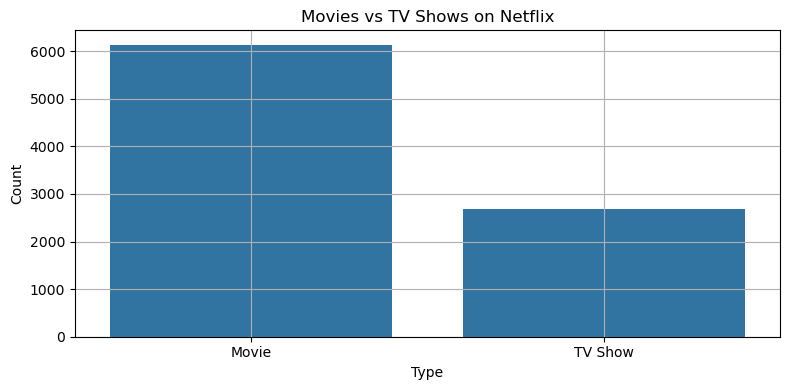

In [73]:
# Data Visualization
# movies vs tv shows
sns.countplot(data=df, x="type")
plt.title("Movies vs TV Shows on Netflix")
plt.xlabel("Type")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()

### 1. Movies vs TV Shows
- According to the dataset, **70% of titles are Movies** and **60% are TV Shows**.  
- Netflix initially focused heavily on movies, but the share of TV shows has **increased steadily after 2015**.

Text(0, 0.5, 'Count')

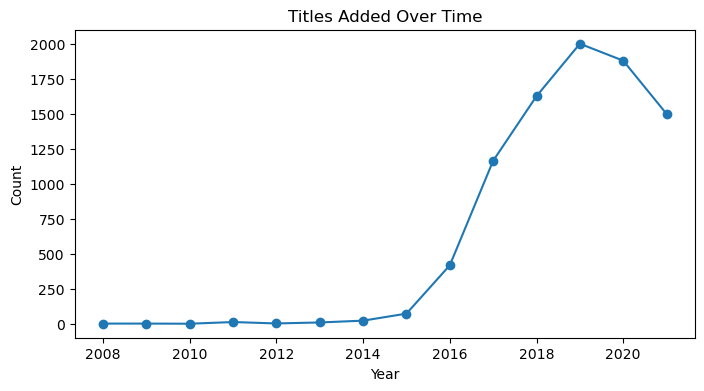

In [74]:
# content added over time (overall)
(df["year_added"].value_counts().sort_index().plot(kind="line", marker="o"))
plt.title("Titles Added Over Time")
plt.xlabel("Year")
plt.ylabel("Count")

### 2. Content Growth Over Time
- The number of titles added to Netflix **grew rapidly from 2015 onwards**.  
- The peak of new content additions occurred around **2018–2019**, followed by a slowdown.  
- This suggests Netflix saturated its library growth and shifted focus to quality/originals.

Text(0, 0.5, 'Count')

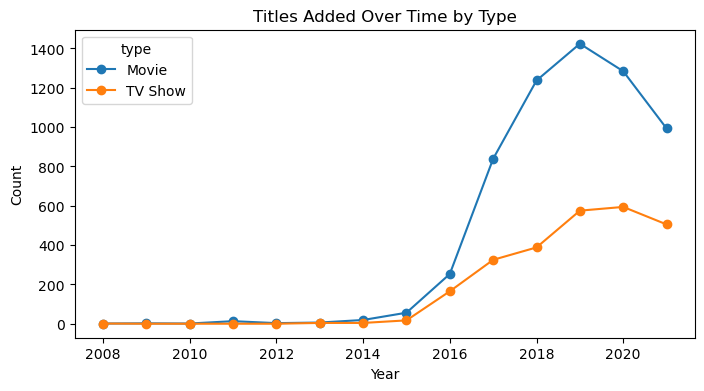

In [75]:
# content added over time by type
added_by_type = (df.groupby(["year_added", "type"]).size().unstack(fill_value=0).sort_index())
added_by_type.plot(marker="o")
plt.title("Titles Added Over Time by Type")
plt.xlabel("Year")
plt.ylabel("Count")

### 3. Content Added by Type
- Movies dominated Netflix’s catalog until ~2015.  
- After 2016, Movies saw a **faster growth rate**, reflecting Netflix’s investment in original series.  


Text(0, 0.5, 'Genre')

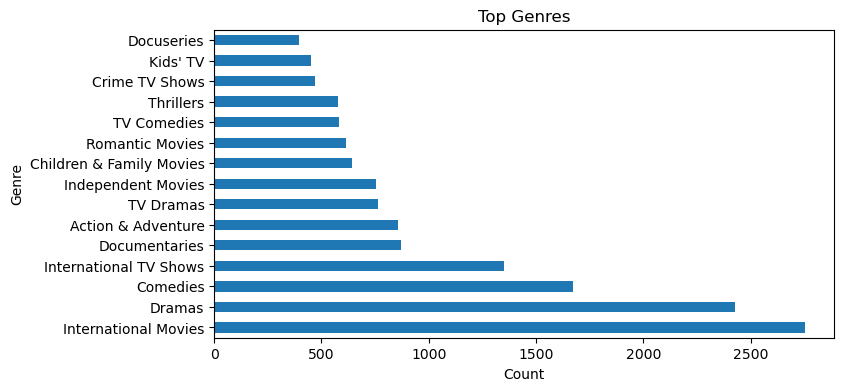

In [76]:
# top genres
genres_exploded.value_counts().head(15).plot(kind="barh")
plt.title("Top Genres"); plt.xlabel("Count"); plt.ylabel("Genre")

### 4. Top Genres
- The most popular genres are **International Movies, Comedies and Dramas**.  
- This shows Netflix’s focus on **global storytelling** and **broad appeal genres** like dramas and comedies.  


Text(0, 0.5, 'Country')

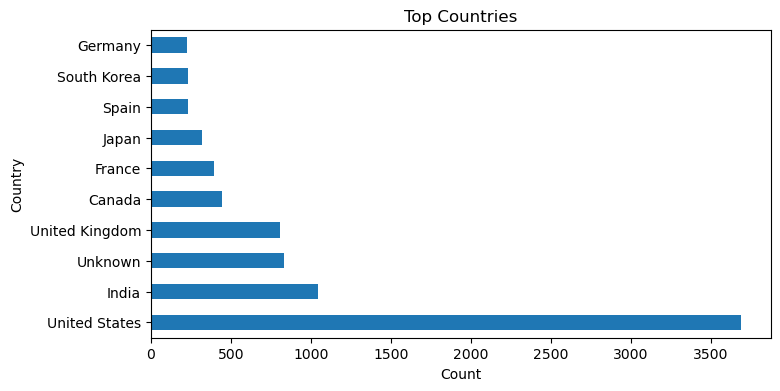

In [77]:
# top countries
countries_exploded.value_counts().head(10).plot(kind="barh")
plt.title("Top Countries")
plt.xlabel("Count")
plt.ylabel("Country")

### 5. Top Countries
- **United States, India, and United Kingdom** contribute the most content.  
- The **United States** has the largest share, but **India and the UK** also contribute significantly.  
- Strong regional representation indicates Netflix’s global expansion strategy.  


Text(0, 0.5, 'Rating')

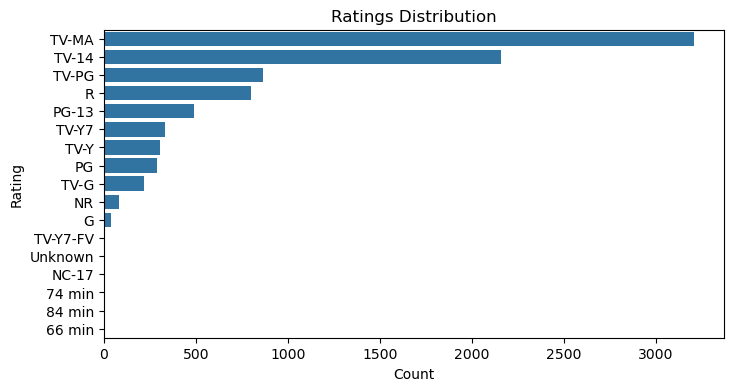

In [78]:
# ratings distribution
order = df["rating"].value_counts().index
sns.countplot(data=df, y="rating", order=order)
plt.title("Ratings Distribution"); plt.xlabel("Count"); plt.ylabel("Rating")

### 6. Ratings Distribution
- Most titles are rated **TV-MA** and **TV-14**, showing a bias toward **teen and adult audiences**.  
- Very few titles fall into children’s categories (TV-Y, TV-G).  


Text(0, 0.5, 'Frequency')

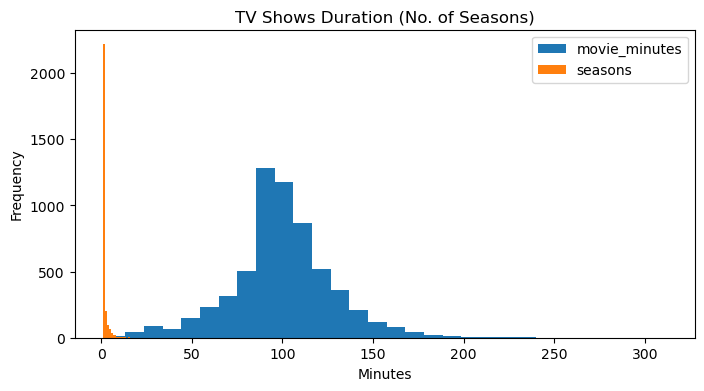

In [86]:
# movie duration & tv seasons distributions
# movie minutes
df.loc[df["is_movie"] == 1, "movie_minutes"].dropna().plot(kind="hist", bins=30)
plt.title("Movie Duration (minutes)"); plt.xlabel("Minutes"); plt.ylabel("Frequency")

df.loc[df["is_tv"] == 1, "seasons"].dropna().plot(kind="hist", bins=15)
plt.title("TV Shows Duration (No. of Seasons)")
plt.legend()
plt.xlabel("Minutes")
plt.ylabel("Frequency")

### 7. Movie Duration
- The **average movie duration** is around **90-120 minutes**.  
- Very few movies exceed **200 minutes**, showing that most content aligns with standard feature film length.  


Text(0, 0.5, 'Median Minutes')

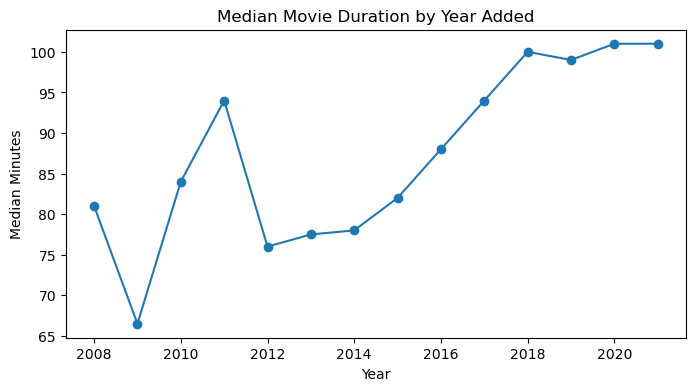

In [87]:
(df[df["is_movie"]==1]
 .groupby("year_added")["movie_minutes"]
 .median()
 .plot(marker="o"))
plt.title("Median Movie Duration by Year Added")
plt.xlabel("Year"); plt.ylabel("Median Minutes")

### 8. TV Show Seasons
- A majority of TV shows are **limited series (1–2 seasons)**.  
- Only a small number of shows extend beyond **5 seasons** — consistent with Netflix’s “binge and done” strategy.  


In [93]:
df["type"].value_counts(normalize=True) * 100

type
Movie      69.615079
TV Show    30.384921
Name: proportion, dtype: float64

In [94]:
df['listed_in'].str.split(',').explode().value_counts().head(5)

listed_in
 International Movies    2624
Dramas                   1600
Comedies                 1210
Action & Adventure        859
Documentaries             829
Name: count, dtype: int64